# Regression Methods for Housing Data
## Matthew Kielar
### ECON 323 001

## Introduction

Throughout the last decade or so, the issue of housing prices has made frequent appearances in newspaper headlines and policymaking circles have often described it as a crisis, especially so in Canada. This begs an important question: what is the extent of this crisis, and how exactly can we assess housing markets in other places? 

To answer this question, it is therefore worth spending some time to put the absurdity of Canada's housing prices into perspective, as well figuring out how to best predict housing values using publicly available data. While policy recommendations are unlikely to be found below, there is nonetheless a good opportunity to get a clearer view into one of the most pressing public policy challenges of our time. 

## Setup 

First, we'll start by importing the requisite libraries for transforming data and generating plots. I personally think that `matplotlib` is an atrocity that should be destroyed in nuclear fire, so we'll be using `plotnine`, which is a nice python wrapper for the excellent ggplot2 library. 

In [94]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

Now we can get to importing and transforming the datasets we'll be using for preliminary plotting.

The first dataset is titled `can_property_prices`, and it tracks the real, non-seasonally adjusted price of a residential property in Canada between 2000 and 2020. The second dataset is titled `can_income`, which tracks real individual income in Canada from 2000 to 2020. 

In [80]:
prop_prices_can = pd.read_csv("can_property_prices.csv")
income_can = pd.read_csv("can_income.csv")

prop_prices_can = (
    prop_prices_can.
    rename(columns = {"DATE": "Date", "QCAR628BIS": "Percent"})
)

prop_prices_can.head()

,Date,Percent
0,2000-01-01,54.9799
1,2000-04-01,55.5592
2,2000-07-01,54.9213
3,2000-10-01,55.1145
4,2001-01-01,54.8502


The resulting `prop_prices_can` dataframe has already had its primary series 'rebased.' This means that each value is represented as a percentage of a specific value at a chosen index. In this case, January 2010 has been chosen as the baseline. 

Now to tidy up the income dataset:

In [81]:
income_can = (
    income_can[
        (income_can['Statistics'] == 'Median income (excluding zeros)')].
    filter(items = ['REF_DATE', 'VALUE']).
    rename(columns = {"REF_DATE": "Date", "VALUE": "Income"}).
    reset_index().
    drop('index', axis = 1)
)

base = income_can.loc[income_can['Date'] == 2010]['Income'].values[0]
income_can['Rebased'] = income_can['Income'] / base * 100

income_can.head()

,Date,Income,Rebased
0,2000,30700,91.641791
1,2001,31600,94.328358
2,2002,31500,94.029851
3,2003,31400,93.731343
4,2004,31800,94.925373


Before diving into data visualization, I'll briefly set the plot theme so I don't have to explicitly construct it every time I create a plot. I'm personally a fan of
lightweight and somewhat minimalist themes instead of ones saturated with pointless junk, so I'll do my best to live up to that philosophy here. 

In [82]:
plot_theme = theme(
    plot_title = element_text(
        face = "bold", size = 12, hjust = 0),
    plot_caption = element_text(
        size = 10, hjust = 0),
    axis_title_x = element_text(
        face = "bold", size = 12),
    axis_title_y = element_text(
        face = "bold", size = 12, angle = 90),
    axis_text = element_text(
        size = 12),
    panel_grid_major_x = element_blank(),
    panel_grid_minor_x = element_blank(),
    panel_grid_major_y = element_line(
        size = 0.1, color = "#808080"),
    panel_grid_minor_y = element_line(
        size = 0.1, color = "#808080"),
    panel_background = element_rect(
        fill = "#FFFFFF"),
    panel_border = element_rect(
        fill = "#000000", size = 1.0),
    plot_background = element_rect(
        fill = "#FFFFFF"),
    legend_title = element_text(
        face = "bold", size = 12),
    legend_text = element_text(
        size = 12),
    legend_background = element_rect(
        fill = "#FFFFFF"),
    legend_key = element_rect(
        fill = "#FFFFFF")
)

## Plotting

Now we can get to plotting some time-series charts to get a better picture of the motivation behind the analysis in this project. After all, a picture is worth a thousand words, and this situation is no exception. That aside, let's see just how much property prices have gone haywire over the last two decades.

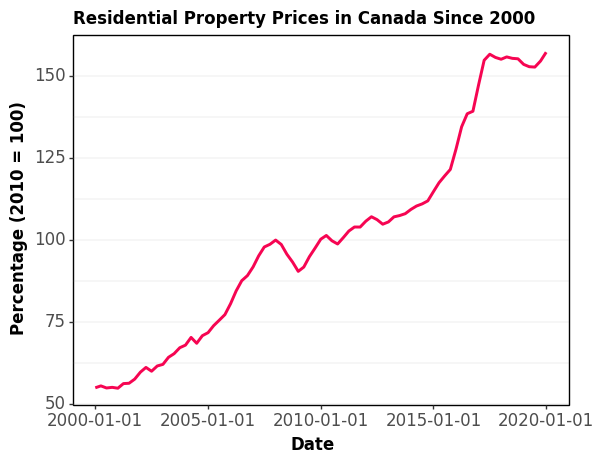

<ggplot: (93127655280)>

In [83]:
price_chart = (ggplot(
    data = prop_prices_can,
    mapping = aes(
        x = 'Date', y = 'Percent', group = 1)
    ) +
    geom_line(
        color = '#F60552', size = 1.2
    ) +
    labs(
        x = 'Date', 
        y = 'Percentage (2010 = 100)',
        title = 'Residential Property Prices in Canada Since 2000'
    ) +
    scale_x_date(
        date_breaks = "5 years"
    ) +
    plot_theme
)

price_chart

This is pretty staggering. The median price of a residential property in Canada increased by approximately 55% between 2010 and 2020. Obviously this proceeded to climb even more following a torrent of monetary stimulus during the Covid pandemic that sent asset prices skyrocketing, but it's still astonishing nonetheless.

But how have incomes fared during that same period?

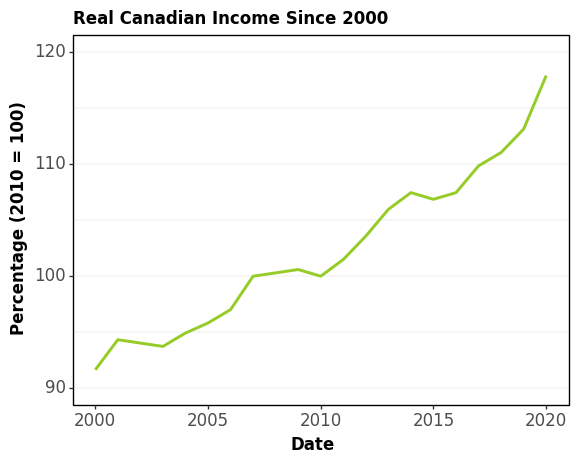

<ggplot: (93127590623)>

In [84]:
income_chart = (ggplot(
    data = income_can) +
    geom_line(
        aes(x = 'Date', y = 'Rebased'),
        color = '#96CC28', size = 1.2
    ) +
    labs(
        x = 'Date',
        y = 'Percentage (2010 = 100)',
        title = 'Real Canadian Income Since 2000'
    ) +
    scale_y_continuous(
        limits = (90, 120)
    ) +
    plot_theme
)

income_chart

The first way to describe to above trend is 'not good.' Between 2010 and 2020, median individual income in Canada increased by around 15%. This is pretty pitiful on its own, but when juxtaposed against the massive increase in housing prices over the same time period, it becomes even more astonishing. Residential property prices have increased over __three times__ as much as income over the last decade, enough to make New York look like a beacon of affordability.

## Now what?

So now that the extent to which housing markets are detached from reality has been put on clear display, predicting property values and analyzing which methods are the best at doing so seems like a particularly salient task to undertake. 

For this, a dataset of housing values in Boston as well as some pertinent variables obtained from a census survey seems like an ideal choice. The dataset can be broken down as follows:

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per $10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
14. MEDV - Median value of owner-occupied homes in $1000's

## Pre-processing

Before any modelling can be done, it's probably best to pre-process the data and split it into a train and test set for evaluation purposes.

In [85]:
# Import libraries for modelling
from sklearn import model_selection, linear_model
import statsmodels.api as sm
from skranger.ensemble import RangerForestRegressor

boston = pd.read_csv("boston.csv")

X = boston.drop('MEDV', axis = 1)
y = boston['MEDV']

boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Ordinary Least Squares

To start, we'll fit an OLS model (a fan favourite of every economist) and use that as a baseline estimate of prediction accuracy that other methods can be compared against. 

In [86]:
# Fit ordinary least squares model 
OLS_model = sm.OLS(endog = y_train, exog = X_train)
OLS_fit = OLS_model.fit()

## Lasso 

Having fitted a regular linear model, it's also worth exploring if a regularized model can improve prediction accuracy as well as identify which variables aren't that important. 

While several methods of penalized regression are available, lasso (L1-penalty) is arguably the most popular one due to its ability to shrink coefficient estimates and perform variable selection. Seems like an ideal choice here, right?

In [87]:
# Fit L1 regularized regression
lasso_model = linear_model.Lasso(alpha = 1.0, warm_start = True)
lasso_fit = lasso_model.fit(X = X_train, y = y_train)

a = np.exp(np.linspace(10, -2, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(
    X_train, y_train, alphas = a, max_iter = 10000)

### Coefficient path

Having fitted a lasso model to the data, it's also important to visualize the how the coefficients behave with the penalty term, otherwise this entire endeavor would be profoundly pointless.

The function below uses the vector of $\alpha$ defined earlier and returns a plot that is pretty helpful in examining how the strength of the penalty term affects the coefficient estimates:

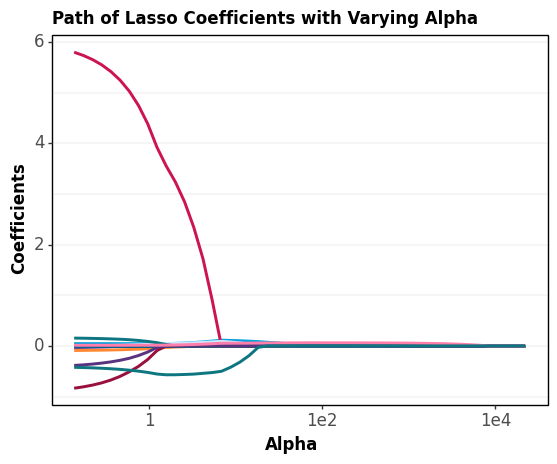

<ggplot: (93125910613)>

In [93]:
def lasso_path(X, y, alpha):
    """
    Takes in a matrix of regressors (X), a vector of response 
    values (y), and a vector of regularization coefficients (alphas)

    Obtains lasso coefficients for each iteration over alphas and
    plots the resulting coefficient trace in ggplot style
    """

    # Obtain coefficients across the whole lasso path
    coefs = []
    for a in alpha:
        lasso = linear_model.Lasso(alpha = a, fit_intercept = False)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
    
    # Create dataframe for plotting the coefficient path
    alpha_coefs = pd.DataFrame(coefs)
    alpha_coefs['alpha'] = alphas
    colors = [
        '#FF8833', '#00A0DD', '#593380', '#0F5499', '#00994D', '#CC1451', 
        '#CCE6FF', '#990F3D', '#0D7680', '#0F5499', '#593380', '#FF7FAA', "#0D7680"]

    # Plot the coefficient path 
    coef_plot = ggplot()
    for i in (range(len(list(alpha_coefs.columns)) - 1)):
        coef_plot = (
            coef_plot + 
            geom_line(
                data = alpha_coefs,
                mapping = aes(x = 'alpha', y = alpha_coefs[i]),
                size = 1.2,
                color = colors[i]) +
            plot_theme)
    
    coef_plot = (
        coef_plot +
        scale_x_log10() +
        labs(
            x = "Alpha",
            y = "Coefficients",
            title = "Path of Lasso Coefficients with Varying Alpha")) 
    
    return coef_plot

lasso_path(X = X_train, y = y_train, alpha = alphas)

This plot provides a neat visualization of the intuition behind the penalty term ($\alpha$ in this case) in a regression model. As the strength of the penalty increases, it should make sense that the coefficients shrink since they're being constrained to a smaller region.

The plot shows exactly this:

* When $\alpha$ is low, the penalty isn't that strong, and we see several non-zero coefficients.

* As $\alpha$ gets higher, all of the coefficients converge towards zero. 

But how does this compare with the OLS model fitted earlier?

In [92]:
OLS_coefs = OLS_fit.params
lasso_coefs = lasso_fit.coef_

coef_table = pd.DataFrame()
coef_table['OLS'] = OLS_coefs
coef_table['lasso'] = lasso_coefs

coef_table

,OLS,lasso
CRIM,-0.095871,-0.063105
ZN,0.043577,0.045144
INDUS,-0.019212,-0.016455
CHAS,0.590982,0.000000
NOX,-4.462140,-0.000000
RM,6.239519,0.972476
AGE,0.000889,0.025881
DIS,-0.962428,-0.661936
RAD,0.156601,0.255765
TAX,-0.009621,-0.015594


As shown in the table above, a few of the lasso estimates (`CHAS` and `NOX`) have been zeroed out, whereas their OLS counterparts are not exactly the closest thing to zero.

## Random Forest

Although regression methods are particularly powerful, it's also worth exploring if tree-based methods offer any advantages for prediction. 

Below, a random forest model has been fitted with 400 trees and 13 candidate splits for each tree.

In [90]:
rf_mod = RangerForestRegressor(
    n_estimators = 400, mtry = len(boston.columns) - 1, oob_error = True)

rf_fit = rf_mod.fit(X_train, y_train)

## Assessing Predictions

So how good are each of these three models, and which one is the best for out-of-sample predictions?

To assess accuracy, different loss functions can be used, but squared-error loss is by far the most common in a regression setting, and it's the one that's used here as well. 

In [91]:
def mean_square_error(obs, pred):
    diff_sq = (obs - pred) ** 2
    mse = np.mean(diff_sq)
    return mse

OLS_preds = OLS_fit.predict(exog = X_test)
lasso_preds = lasso_model.predict(X_test)
rf_preds = rf_mod.predict(X = X_test)

model_errors = {
    'Method' : ['OLS', 'Lasso', 'RF'],
    'MSE' : [
        round(mean_square_error(obs = y_test, pred = OLS_preds), 2),
        round(mean_square_error(obs = y_test, pred = lasso_preds), 2),
        round(mean_square_error(obs = y_test, pred = rf_preds), 2)
    ]
}

MSE = pd.DataFrame.from_dict(model_errors)
MSE

,Method,MSE
0,OLS,28.22
1,Lasso,29.99
2,RF,7.11


It turns out that lasso had the poorest performance, which is surprising since the entire point of regularization is to improve prediction accuracy.

On the other hand, random forest left the other models behind in the dust in terms of performance, which is unusual since decision trees normally sacrifice predictive power to improve interpretatbility. This is very interesting indeed, but a detailed explanation is beyond the scope of this project, so I'll leave it here for now.

## Conclusion

While the analysis performed in this project serves as an interesting launchpad for further investigation into the issue of housing prices, there are a few things that one should take into account before applying these methods in greater depth.

* OLS is nice and efficient, but data isn't linear all the time, and linear models suffer in the presence of non-linear data.

* Regularization works great for high-dimensional data, but some datasets might not have enough predictors for methods like ridge or lasso to offer substantial improvements over OLS. 

* Tree-based methods like random forest add extra tuning parameters, which have to be chosen carefully.

Overall, there is no silver bullet statistical learning solution to prediction problems, and the context of this project is no different. While housing markets have showed some indication of cooling down in recent months, the way they have behaved over the last two decades will continue to puzzle economists and statisticians for some time to come. Although the analysis utilized in this project is trivial in the grand scheme of things, its is nonetheless a snapshot into what methods might be used to predict the next housing crisis.

__Link to github repository:__

[econ323-final-project](https://github.com/mattkielar/econ323-final-project)